In [1]:
import langgraph
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

In [2]:
import os

llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))

/tmp/ipykernel_20475/3971565783.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))


In [3]:
def code_style_check(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드의 스타일을 점검하고 PEP8 준수 여부를 확인하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["style_feedback"] = response.content
    return inputs

def bug_detection(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드에서 잠재적인 버그나 논리적 오류를 찾아 설명하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["bug_feedback"] = response.content
    return inputs

def optimization_suggestions(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드를 더 효율적으로 최적화할 수 있는 방법을 제안하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["optimization_feedback"] = response.content
    return inputs

def aggregate_feedback(inputs):
    code = inputs["code"]
    feedback = (
        "코드 스타일 피드백:\n" + inputs["style_feedback"] + "\n\n"
        "버그 가능성 분석:\n" + inputs["bug_feedback"] + "\n\n"
        "최적화 제안:\n" + inputs["optimization_feedback"]
    )
    prompt = (
        "다음 코드와 피드백을 바탕으로 개선된 코드를 작성하세요. 반드시 코드만 출력해야 합니다.\n" + \
            "code: " + code + "\n\n" \
            "피드백: " + feedback
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"code": response.content, "final_feedback": feedback}

In [4]:
from langgraph.graph import END, Graph, START

# LangGraph 워크플로우 구축
graph = Graph()
graph.add_node("style_check", code_style_check)
graph.add_node("bug_check", bug_detection)
graph.add_node("optimization_check", optimization_suggestions)
graph.add_node("aggregate", aggregate_feedback)

# 데이터 흐름 정의
graph.add_edge(START, "style_check")
graph.add_edge("style_check", "bug_check")
graph.add_edge("bug_check", "optimization_check")
graph.add_edge("optimization_check", "aggregate")
graph.add_edge("aggregate", END)

app = graph.compile()


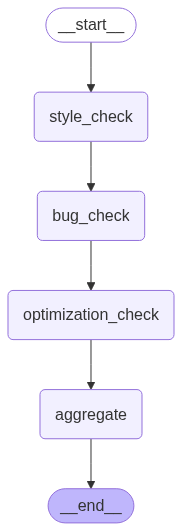

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
sample_code = """
def add_numbers(a, b):
return a+b
"""
result = app.invoke({"code": sample_code})
print(result["final_feedback"])

코드 스타일 피드백:
주어진 코드의 스타일을 점검하고 PEP 8 준수 여부를 확인해 보겠습니다. 현재 코드:

```python
def add_numbers(a, b):
return a+b
```

PEP 8에 따르면 다음과 같은 규칙들이 있습니다:

1. **들여쓰기**: 코드 블록은 4칸의 공백으로 들여쓰기 해야 합니다.
2. **공백**: 연산자(예: `+`) 양쪽에 공백을 추가해야 합니다.
3. **함수 정의**: 함수 정의와 본문 사이에 빈 줄은 필요하지 않지만, 들여쓰기를 적절히 해주어야 합니다.

따라서, 위의 코드를 PEP 8에 맞게 수정하면 다음과 같습니다:

```python
def add_numbers(a, b):
    return a + b
```

이렇게 수정하면 PEP 8 스타일 가이드에 부합하게 됩니다.

버그 가능성 분석:
제공된 코드에서 잠재적인 버그나 논리적 오류를 설명하겠습니다:

1. **들여쓰기 오류**: `return` 문이 `add_numbers` 함수 내부에 있어야 하지만, 현재는 들여쓰기가 되어 있지 않아 함수의 일부로 인식되지 않습니다. 파이썬에서는 들여쓰기가 문법적으로 중요하므로, 올바른 들여쓰기를 적용해야 합니다. 수정된 코드는 다음과 같습니다:

   ```python
   def add_numbers(a, b):
       return a + b
   ```

2. **입력 검증 부족**: 함수가 두 개의 인자를 받아서 덧셈을 수행하지만, 입력 값이 숫자 타입인지 확인하지 않습니다. 만약 `a` 또는 `b`가 숫자가 아닌 경우, TypeError가 발생할 수 있습니다. 이를 방지하기 위해 입력 값을 검증하는 로직을 추가하는 것이 좋습니다. 예를 들어:

   ```python
   def add_numbers(a, b):
       if not isinstance(a, (int, float)) or not isinstance(b, (int, float)):
           raise ValueErr

In [7]:
print(result["code"])

```python
def add_numbers(a: float, b: float) -> float:
    if not isinstance(a, (int, float)) or not isinstance(b, (int, float)):
        raise ValueError("Both a and b must be numbers.")
    return a + b
```
